In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from pathlib import Path
from collections import Counter
import random
from PIL import Image
import torchvision.transforms.functional as TF

In [6]:
from zipfile import ZipFile
file_name = "interim.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

train_data_path = '/content/interim'
for root, dir, files in os.walk(train_data_path):
  for dir_name in dir:
    print(f'Subfolder: {dir_name}')

Done
Subfolder: Seborrheic Keratoses and other Benign Tumors
Subfolder: Herpes HPV and other STDs Photos
Subfolder: Eczema Photos
Subfolder: Melanoma Skin Cancer Nevi and Moles
Subfolder: Cellulitis Impetigo and other Bacterial Infections
Subfolder: Atopic Dermatitis Photos
Subfolder: Vascular Tumors
Subfolder: Acne and Rosacea Photos


dict_items([(0, 840), (1, 100), (2, 65), (3, 35), (4, 40), (5, 24), (6, 80), (7, 101)])
Training class distribution
Acne and Rosacea Photos: 840 images
Atopic Dermatitis Photos: 100 images
Cellulitis Impetigo and other Bacterial Infections: 65 images
Eczema Photos: 35 images
Herpes HPV and other STDs Photos: 40 images
Melanoma Skin Cancer Nevi and Moles: 24 images
Seborrheic Keratoses and other Benign Tumors: 80 images
Vascular Tumors: 101 images


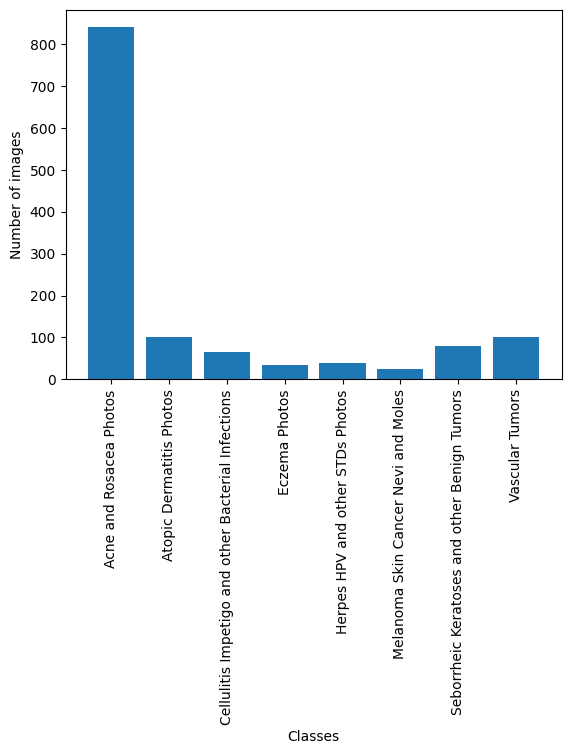

Text(0, 0.5, 'Number of images')

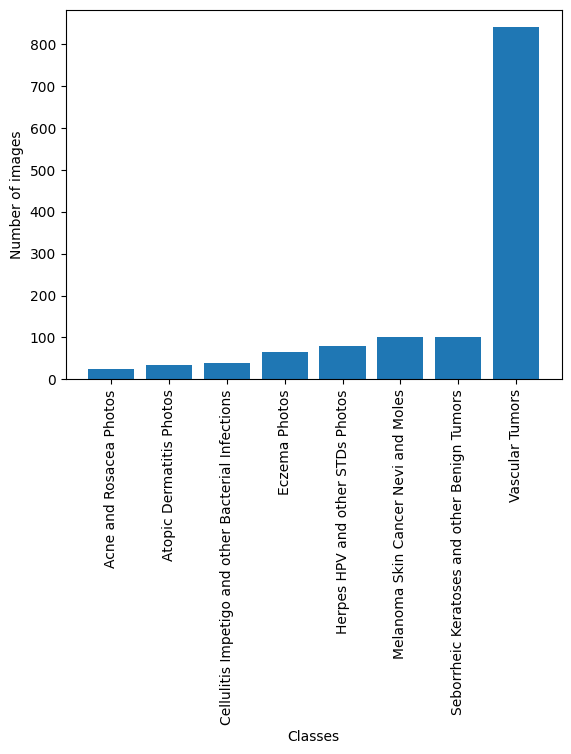

In [10]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
train_class_counts = Counter(train_dataset.targets)
sorted_train_class_counts = sorted(train_class_counts.items(), key=lambda x: x[1])
class_names = [train_dataset.classes[class_id] for class_id, _ in sorted_train_class_counts]
class_sizes = [count for _, count in sorted_train_class_counts]
print(train_class_counts.items())
print("Training class distribution")
for class_id, count in train_class_counts.items():
  print(f"{train_dataset.classes[class_id]}: {count} images")

plt.figure()
plt.bar(train_class_counts.keys(), train_class_counts.values(), tick_label = [train_dataset.classes[i] for i in train_class_counts.keys()])
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.xticks(rotation=90)
plt.show()
plt.bar(class_names, class_sizes, tick_label = [train_dataset.classes[i] for i in train_class_counts.keys()])
plt.xticks(rotation=90)
plt.xlabel("Classes")
plt.ylabel("Number of images")


Label distribution: {0: 840, 1: 600, 2: 565, 3: 535, 4: 540, 5: 524, 6: 580, 7: 601}


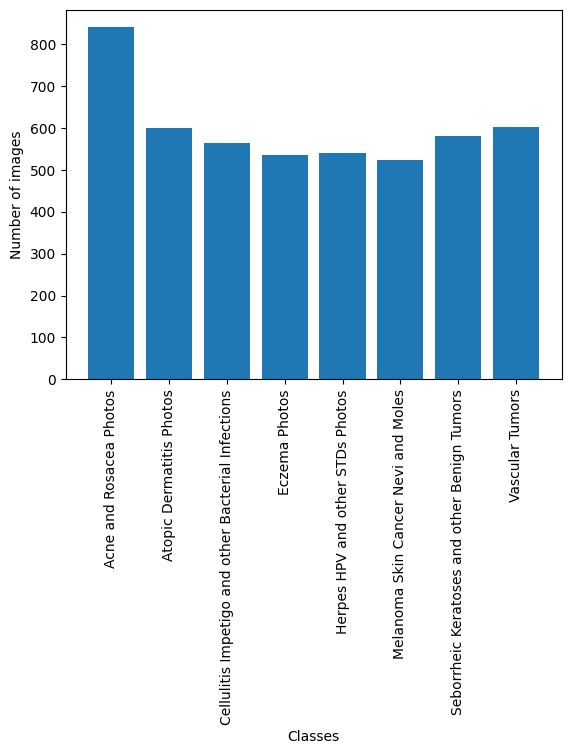

In [16]:
default_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

transform1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

transform2 = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

class CustomDataset(Dataset):
    def __init__(self, real_data, labels_to_generate, transform):
        """
        Args:
            real_data (Dataset): A real dataset containing images and labels (e.g., ImageFolder).
            labels_to_generate (list): List of labels for which synthetic data will be generated.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.real_data = real_data
        self.labels_to_generate = labels_to_generate if isinstance(labels_to_generate, list) else [labels_to_generate]
        self.transform = transform

        # Preprocess - separate data by label and count classes
        self.class_counts = {}
        self.target_class_indices = {}

        # Initialize indices dictionary for each label
        for label in self.labels_to_generate:
            self.target_class_indices[label] = []

        # Count samples per class and store indices of target classes
        for idx, (_, label) in enumerate(self.real_data.samples):
            if label in self.class_counts:
                self.class_counts[label] += 1
            else:
                self.class_counts[label] = 1

            # Store indices for each target label
            if label in self.labels_to_generate:
                self.target_class_indices[label].append(idx)

        # Calculate synthetic samples needed for each label
        self.synthetic_samples_per_label = {}
        self.total_synthetic_samples = 0

        # Find the maximum class count
        max_class_count = max(self.class_counts.values()) if self.class_counts else 0

        # Calculate how many synthetic samples to add for each label
        for label in self.labels_to_generate:
            if label in self.class_counts and self.class_counts[label] < max_class_count:
                # Balance to the max class count (or use a fixed number like 100)
                samples_needed = 500
                self.synthetic_samples_per_label[label] = samples_needed
                self.total_synthetic_samples += samples_needed
            else:
                self.synthetic_samples_per_label[label] = 0

        # Create mapping from synthetic index to (label, index within that label)
        self.synthetic_index_map = []
        for label in self.labels_to_generate:
            for i in range(self.synthetic_samples_per_label.get(label, 0)):
                self.synthetic_index_map.append(label)

        # Cache for synthetic samples
        self.synthetic_cache = {}

    def __len__(self):
        """
        Length of the dataset including all synthetic samples.
        """
        return len(self.real_data) + self.total_synthetic_samples

    def __getitem__(self, idx):
        """
        Get item by index.
        If the index is for synthetic data, generate synthetic sample for the appropriate label.
        """
        # If index exceeds the real dataset length, create synthetic data
        if idx >= len(self.real_data):
            synthetic_idx = idx - len(self.real_data)

            # Check cache first
            if synthetic_idx in self.synthetic_cache:
                return self.synthetic_cache[synthetic_idx]

            # Determine which label to generate for this synthetic index
            label_to_generate = self.synthetic_index_map[synthetic_idx]

            # Generate synthetic sample for this label
            synthetic_sample = self._generate_synthetic_sample(label_to_generate)

            # Cache the result
            self.synthetic_cache[synthetic_idx] = synthetic_sample
            return synthetic_sample

        # Return real data with transforms if applicable
        image, label = self.real_data[idx]

        # Apply transformations if this is one of our target labels
        if label in self.labels_to_generate and self.transform:
            image = self.transform(image)

        return image, label

    def _generate_synthetic_sample(self, label):
        """
        Generate synthetic data by augmenting real images of the specified label.
        """
        if not self.target_class_indices.get(label, []):
            # Fallback if no samples of target class found
            return self.real_data[0]

        # Get a random sample from our precomputed list of target class indices
        random_idx = random.choice(self.target_class_indices[label])
        image, _ = self.real_data[random_idx]

        # Apply transformations to create synthetic data
        if self.transform:
            image = self.transform(image)

        return image, label


labels_to_transform = [1,2, 3, 4, 5, 6, 7]
# Create base dataset
train_dataset = datasets.ImageFolder(root=train_data_path, transform=default_transform)

# Create augmented dataset with multiple labels
augmented_dataset = CustomDataset(train_dataset, labels_to_transform, transform1)

# Efficiently count labels without loading images
label_counter = Counter()

# Count real samples
for _, label in train_dataset.samples:
    label_counter[label] += 1

# Add synthetic samples to counter
for label in labels_to_transform:
    if label in augmented_dataset.synthetic_samples_per_label:
        label_counter[label] += augmented_dataset.synthetic_samples_per_label[label]

print(f"Label distribution: {dict(label_counter)}")
plt.figure()
plt.bar(label_counter.keys(), label_counter.values(), tick_label = [train_dataset.classes[i] for i in train_class_counts.keys()])
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.xticks(rotation=90)
plt.show()